# 基于InsightFace的人脸识别

## 一、综述  

这篇教程我们将介绍用InsightFace进行人脸检测的基本流程。  
工业级的人脸识别需要包含4个步骤：  
   * 人脸检测（detection），将图片中的人脸检测切割出来，并计算关键点（landmark）用于人脸矫正。  
   * 人脸矫正（alignment），检测到的人脸可能有各种角度、表情，矫正可以将人脸调整到接近标准模板，提高识别率。  
   * 姿态过滤，利用姿态预估模型计算人脸的姿态，过滤掉偏转角度过大的人脸。  
   * 人脸识别，计算矫正过的人脸的特征码（embedding），计算它与底库特征码的距离，当最小距离小于阀值时，认为识别成功，数据底库特征码对应的身份ID。  

由于教程中是使用静态图像做识别，可以挑选偏转角度不太大的人脸，我们将忽略姿态过滤，直接用检测矫正后的人脸进行识别。  
如果是使用摄像头对视频进行识别，则应该加上姿态估计和过滤，避免对大角度人脸的错误识别。  

## 二、环境  

在基于RetinaFace的人脸检测中已经介绍过InsightFace的环境。**这里同样请大家从Notebook Kernel菜单中切换Kernal到mxnet_python2环境。**  
InsightFace的[Model-Zoo](https://github.com/deepinsight/insightface/wiki/Model-Zoo)提供了基于多个数据集的预训练模型，我们进行了迁移学习，在LFW测试集上可以达到0.99的精确度。  


In [1]:
# import dependencies

import os
import time
import sys
import random
import datetime
from multiprocessing import Process
from collections import namedtuple

import cv2
import numpy as np
import mxnet as mx
from skimage import transform
import matplotlib.pyplot as plt
%matplotlib inline 

sys.path.append(os.path.join(os.path.abspath(''), 'RetinaFace'))
from retinaface import RetinaFace


## 三、数据  

人脸识别需要2部分数据，底库图片和待识别图片。  
底库图片放置在当前目录下的data/db内，需要正方形正面清晰免冠照片，用“姓名.jpg”命名，我们预置了几张名人标准照作为示例图片。  
待识别图片放置在当前目录下data/test内，也已经有一些教程预置图片，姿态、环境各异。  


In [2]:
db_picture_path = os.path.join(os.path.abspath(''), 'data/db')
test_picture_path = os.path.join(os.path.abspath(''), 'data/test')


## 四、检测  

我们首先进行人脸检测，从测试图片中找到并切割出人脸。  
具体方法在人脸检测教程中已经描述，这里不再详细介绍。  


[32, 16, 8] {'32': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (32, 16)}, '8': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (2, 1)}, '16': {'ALLOWED_BORDER': 9999, 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'SCALES': (8, 4)}}
means [0. 0. 0.]
use_landmarks True
sym size: 9
4.jpg: spent 1.062705 sec(s), detected 3 face(s)


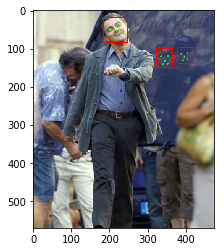

2.jpg: spent 0.943898 sec(s), detected 4 face(s)


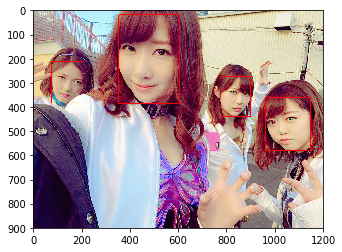

In [ ]:
def draw_on_img(img, faces, landmarks=None):
    for i in range(faces.shape[0]):
        box = faces[i].astype(np.int)
        
        color = (0, 0, 255)
        cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), color, 2)
        
        if landmarks is not None:
            landmark5 = landmarks[i].astype(np.int)
            
            for l in range(landmark5.shape[0]):
                color = (0, 255, 0)
                cv2.circle(img, (landmark5[l][0], landmark5[l][1]), 1, color, 2)
                
    plt.imshow(img[..., ::-1])
    plt.show()
    
def get_img_scale(img_shape, scales):
    target_size, max_size = scales
    
    img_size_min = np.min(img_shape[0:2])
    img_size_max = np.max(img_shape[0:2])
    
    img_scale = float(target_size) / float(img_size_min)
    
    if np.round(img_scale * img_size_max) > max_size:
        img_scale = float(max_size) / float(img_size_max)
        
    return img_scale

def detect(img_dir, filename):
    arr = filename.split('.')

    if len(arr) > 1 and arr[1] == 'jpg':
        # read image
        img_path = os.path.join(img_dir, filename)
        img = cv2.imread(img_path)

        img_scale = get_img_scale(img.shape, image_scales)
        
        start_time = datetime.datetime.now()
        
        faces, landmarks = detector.detect(
            img,
            score_threshold,
            scales=[img_scale],
            do_flip=False
        )
        
        end_time = datetime.datetime.now()
        time_diff = end_time - start_time
        
        img_faces = []
        
        print('{}: spent {} sec(s), detected {} face(s)'.format(
            entry,
            time_diff.total_seconds(),
            faces.shape[0]
        ))
        
        draw_on_img(img.copy(), faces, landmarks=landmarks)
        
        return img, faces, landmarks

# consts
score_threshold = 0.94
image_scales = [720, 1024]

# init detector - mxnet selects cpu if gpu_id < 0
gpu_id = -1
detector = RetinaFace('../../../share/pro_face_recognition/model/R50', 0, gpu_id, 'net3')

# list input pics
entries = os.listdir(test_picture_path)

img_list = []
bbox_list = []
landmark_list = []

for entry in entries:
    img, bboxes, landmarks = detect(test_picture_path, entry)
    
    img_list.append(img)
    bbox_list.append(bboxes)
    landmark_list.append(landmarks)
        

# 五、矫正  

检测到的人脸有各种姿态和角度，如果根据Landmark（关键点）加以矫正，可以提高识别正确率。  
矫正算法的思路是，定义一个标准关键点模板，计算检测到的关键点到标准模板的变换，并对人脸图像执行相同的变换，则实现了对人脸图像的矫正。  
如果图片中有多张人脸，我们只识别最大的一张人脸，这在人脸打卡、闸机等系统是常见处理。对于不同的应用，可以采用不同的过滤规则。  


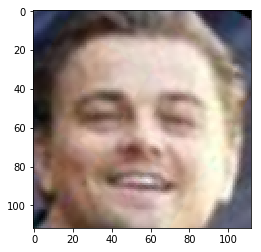

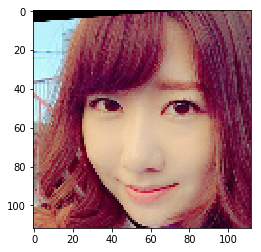

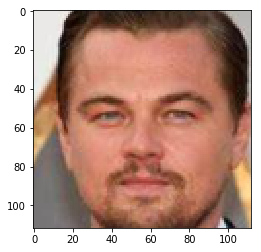

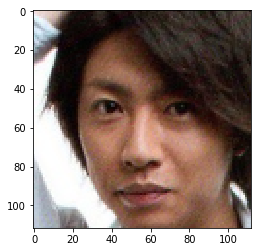

In [13]:
def wrap_face(img, faces, landmarks):
    max_size = 0
    max_box= []
    max_landmark = []

    if len(faces) != 0 or len(landmarks) != 0:
        # find out the max face
        for i in range(faces.shape[0]):
            box = faces[i]
            size = (box[0] - box[2]) * (box[1] - box[3])
            
            if size > max_size:
                max_box = box
                max_landmark  = landmarks[i].astype(np.int)
                max_size = size
                
        # config and template
        image_size = [112, 112]
        src = np.array([
            [30.2946, 51.6963],
            [65.5318, 51.5014],
            [48.0252, 71.7366],
            [33.5493, 92.3655],
            [62.7299, 92.2041]], dtype=np.float32)
        
        # template was created for 96x112 pic
        # adjust point position for 112x112
        if image_size[1] == 112:
            src[:, 0] += 8.0
            
        # OK, transform
        warped = None

        if max_landmark is not None:
            tform = transform.SimilarityTransform()
            tform.estimate(max_landmark, src)
            M = tform.params[0:2, :]
            warped = cv2.warpAffine(img, M, (image_size[1], image_size[0]), borderValue=0.0)
            
            plt.imshow(warped[..., ::-1])
            plt.show()
            
            return warped

warped_faces = []

for idx, (img, faces, landmarks) in enumerate(zip(img_list, bbox_list, landmark_list)):
    warped_face = wrap_face(img, faces, landmarks)
    
    warped_faces.append(warped_face)
    

## 六、制作底库  

底库图片同样需要利用RetinaFace检测，并进行矫正，再执行特征提取。  
我们定义一个ExtractFeature类来进行特征计算。  


In [14]:
class ExtractFeature:
    def __init__(self, prefix, epoch, gpu_id=-1):
        sym, arg_params, aux_params = mx.model.load_checkpoint(prefix, epoch)
        
        if gpu_id < 0:
            self.mod = mx.mod.Module(symbol=sym, context=mx.cpu(0))
        else:
            self.mod = mx.mod.Module(symbol=sym, context=mx.gpu(gpu_id))

        # 获取网络结构
        internals = self.mod.symbol.get_internals()

        # 获取从输入到特征值层的模型
        feature_net = internals["fc1_output"]

        if gpu_id < 0:
            self.feature_model = mx.module.Module(symbol=feature_net, context=mx.cpu(0))
        else:
            self.feature_model = mx.module.Module(symbol=feature_net, context=mx.gpu(gpu_id))

        data_shapes = [('data', (1, 3, 112, 112))]
        self.feature_model.bind(data_shapes=data_shapes)

        # 上面只是定义了结构，这里设置特征模型的参数为Inception_BN的
        self.feature_model.set_params(
            arg_params=arg_params,
            aux_params=aux_params,
            allow_missing=False
        )

    def bufferDecode(self, str_image):
        data = np.fromstring(str_image, dtype='uint8')
        return cv2.imdecode(data, 1)

    def do_flip(self, data):
        for idx in xrange(data.shape[0]):
            data[idx, :, :] = np.fliplr(data[idx, :, :])

    def ExtractFeature(self, image, b_flip):
        if isinstance(image, str):
            imgsrc = cv2.imread(image)
        else:
            imgsrc = image
            
        img = cv2.resize(imgsrc, (112, 112), interpolation=cv2.INTER_CUBIC)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img = np.swapaxes(img, 0, 2)
        img = np.swapaxes(img, 1, 2)

        embedding = None

        fliplist = []
        
        if b_flip == True:
            fliplist = [0, 1]
        else:
            fliplist = [0]

        for flipid in fliplist:
            _img = np.copy(img)
            if flipid == 1:
                self.do_flip(_img)

            Batch = namedtuple('Batch', ['data'])
            data = Batch([mx.nd.array(np.array([_img]))])

            # 输出特征
            self.feature_model.forward(data, is_train=False)
            _embedding = self.feature_model.get_outputs()[0].asnumpy()
            if embedding is None:
                embedding = _embedding
            else:
                embedding += _embedding

        _norm = np.linalg.norm(embedding)
        embedding /= _norm

        return embedding


In [18]:
# consts
recog_model_prefix = '../../../share/pro_face_recognition/model/feature'
model_epoch = 0

# mxnet selects cpu if gpu_id < 0
extractor = ExtractFeature(recog_model_prefix, model_epoch, gpu_id=-1)


在实际的人脸识别系统中，计算完成的embedding可以保存数据库，供识别模型调用。  
在教程中我们只要直接保存在dict变量中就可以了。  
读出底库图片并提取embedding：  

LeonardoDicaprio.jpg: spent 0.731113 sec(s), detected 1 face(s)


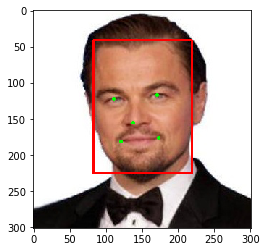

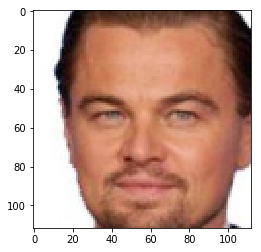

YukiKashiwagi.jpg: spent 0.759513 sec(s), detected 1 face(s)


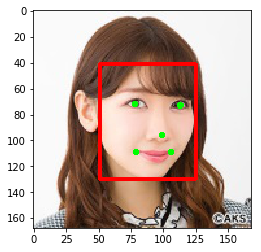

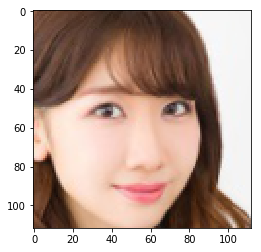

MasakiAiba.jpg: spent 0.783863 sec(s), detected 1 face(s)


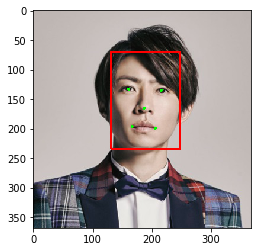

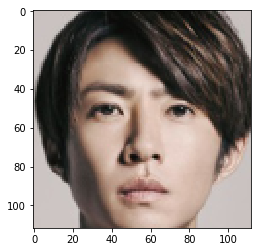

{'MasakiAiba': array([[-7.98854791e-03,  3.00044976e-02, -5.03060333e-02,
         1.10018542e-02,  5.24488315e-02,  1.34592596e-02,
        -2.49022879e-02, -3.67085859e-02, -6.99432716e-02,
        -1.70430876e-02, -3.54878902e-02,  1.69789442e-03,
        -5.14925532e-02, -2.46228594e-02,  2.82295998e-02,
        -5.24340756e-03, -1.16388286e-02,  2.80925608e-03,
         5.03012501e-02,  5.31563200e-02,  1.23467259e-02,
         1.07423719e-02,  5.74154779e-02,  5.29292561e-02,
        -4.99952734e-02, -7.92308971e-02, -5.24128266e-02,
        -6.85075447e-02,  2.93578357e-02,  3.62191126e-02,
         1.70076154e-02, -1.07240956e-02, -4.05820422e-02,
        -3.92508134e-02,  2.77189352e-03, -1.52681414e-02,
         4.41472903e-02, -3.55562312e-03,  4.61837500e-02,
        -2.45657135e-02,  2.50285538e-03, -1.77560393e-02,
        -2.47505587e-02, -4.10976540e-03, -7.77563138e-04,
         3.54788899e-02,  3.42496932e-02, -5.81982546e-02,
         1.15867844e-02, -4.80220765e-02,

In [19]:
# list db pics
entries = os.listdir(db_picture_path)

id_list = {}

for entry in entries:
    arr = entry.split('.')
    
    if len(arr) > 1 and arr[1] == 'jpg':
        img, bboxes, landmarks = detect(db_picture_path, entry)
        wraped_face = wrap_face(img, bboxes, landmarks)
        
        # get embedding
        embedding = extractor.ExtractFeature(wraped_face, False)
        
        # save embedding
        id_list[arr[0]] = embedding

print(id_list)

## 七、识别  

计算每个人脸的特征，并与底库比对：  

pic: 0, id: LeonardoDicaprio, similarity: 0.708802998066


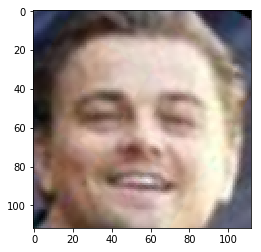

pic: 1, id: YukiKashiwagi, similarity: 0.690861523151


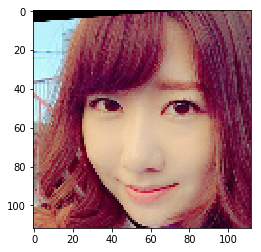

pic: 2, id: LeonardoDicaprio, similarity: 0.898994326591


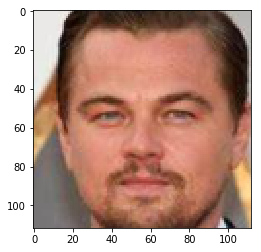

pic: 3, id: MasakiAiba, similarity: 0.699566304684


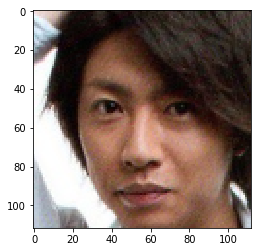

In [17]:
# 相似度计算函数
def calc_similarity(Feature1, Feature2):
    return np.dot(Feature1, Feature2) / (np.linalg.norm(Feature1) * np.linalg.norm(Feature2))

for i, face in enumerate(warped_faces):
    face_feature = extractor.ExtractFeature(face, False)

    face_scores = []

    for name in id_list.keys():
        id_feature = id_list[name]

        similarity = calc_similarity(face_feature.squeeze(), id_feature.squeeze())
        face_scores.append(similarity)

    max_score = np.max(face_scores)
    max_id = np.argmax(face_scores)

    if max_score > 0.00:
        name = id_list.keys()[max_id]
    else:
        name = 'Unknown'

    print('pic: {}, id: {}, similarity: {}'.format(i, name, max_score))
    plt.imshow(face[..., ::-1])
    plt.show()

## 八、总结和展望

本教程介绍的人脸识别流程，使用预训练模型，达到工业级别效果，可以直接应用于实际项目、比赛中。  
在整个流程中最耗时的步骤是人脸检测，矫正和识别速度都相当快。总的来说，在CPU上运行静态图片是可以达到实用水平的。  

对于大角度的人脸，一般思路是通过Landmark计算角度，如果大于一个阀值，则不再进行识别。  

## 九、思考题

1. 请给矫正和识别添加统计用时的代码，它们分别需要多少时间？对于不同的人脸，计算时间有变化吗？为什么？  
2. 你可以上传自己的标准照和生活照，进行人脸识别吗？  
请动手试一试。  
